In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
import eda

## 유동인구

**성연령**

In [2]:
age = eda.flow_concat('AGE','../data/01_SKT/*.csv')
age = eda.flow_preprocessing(age)
age = eda.flow_melting(age)
age['AGE_CD'] = age['VAR'].apply(lambda x: x[-3:] if x[-4] == '_' else x[-4:])
age['SEX_CD'] = age['VAR'].str[0].map({'M':'M', 'W':'F'})
age = age[['STD_YMD', 'GU_NM', 'HDONG_NM', 'SEX_CD', 'AGE_CD', 'POP_CNT']]
age_dict = {x: int(x[:2])for x in sorted(age['AGE_CD'].unique())}
age['AGE_CD'] = age['AGE_CD'].map(age_dict)
age['AGE_CD'] = age['AGE_CD'].apply(lambda x: 20 if x < 20 else x)
age['AGE_CD'] = age['AGE_CD'].apply(lambda x: 65 if x > 65 else x)
age = age.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['POP_CNT'].sum().reset_index()
age_per = pd.read_csv('../data/08_Percent_Matrix/age_per.csv')
age = pd.concat([age, age_per],axis=1)


print(age.shape)
age.head()

(16629, 14)


,STD_YMD,GU_NM,HDONG_NM,POP_CNT,AG_20_F,AG_30_F,AG_40_F,AG_50_F,AG_60_F,AG_20_M,AG_30_M,AG_40_M,AG_50_M,AG_60_M
0,2019-02-01,대구 수성구,고산1동,133361.08,0.094684,0.066612,0.117062,0.099566,0.070804,0.104180,0.085641,0.131000,0.129117,0.101335
1,2019-02-01,대구 수성구,고산2동,254912.57,0.077246,0.067818,0.099493,0.087825,0.068341,0.096442,0.106579,0.147573,0.143406,0.105276
2,2019-02-01,대구 수성구,고산3동,57764.08,0.091888,0.073853,0.112215,0.098319,0.071726,0.098732,0.089873,0.129602,0.128439,0.105352
3,2019-02-01,대구 수성구,두산동,125647.42,0.077910,0.078633,0.113528,0.091201,0.078017,0.082605,0.106474,0.141090,0.126571,0.103969
4,2019-02-01,대구 수성구,만촌1동,132277.61,0.079484,0.067034,0.095607,0.091221,0.075020,0.098307,0.100490,0.136893,0.139035,0.116909


**시간**

In [3]:
time = eda.flow_concat('TIME','../data/01_SKT/*.csv')
time = eda.flow_preprocessing(time)

print(time.shape)
time.head()

(16629, 27)


,STD_YMD,GU_NM,HDONG_NM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,...,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23
0,2019-02-01,서울 중구,소공동,1496.35,1022.83,706.51,547.77,1673.02,3561.05,9195.82,...,12355.91,13096.69,9317.64,15029.74,14135.83,9074.02,6032.26,6047.05,4806.65,2956.11
1,2019-02-01,서울 중구,회현동,1692.37,1117.26,839.57,653.41,1920.52,4687.95,10936.47,...,18210.30,20292.65,12527.29,21454.63,18214.50,11914.26,9800.64,9341.24,6884.91,4034.56
2,2019-02-01,서울 중구,명동,2226.91,1726.10,1145.43,894.97,2513.32,5268.51,13857.93,...,20332.71,21458.64,14434.56,25855.14,23107.23,13460.05,9797.40,8719.30,7203.45,4845.48
3,2019-02-01,서울 중구,필동,698.73,440.70,385.99,275.64,497.41,1990.42,4679.79,...,6900.66,9789.54,6205.74,13277.25,12101.51,5698.58,4464.46,4088.53,3385.14,1746.28
4,2019-02-01,서울 중구,장충동,768.34,447.23,429.90,349.46,507.74,1310.67,2956.49,...,5187.02,5211.60,3656.54,6841.98,5810.71,4463.99,2807.25,2626.12,2415.41,1398.94


In [4]:
total = time.loc[: , 'TMST_00':].sum(axis=1)
for i in time.columns[3:].str[-2:]:
    time[f'TMST_{i}'] = time[f'TMST_{i}'] / total

In [5]:
flow = pd.merge(age, time, on=['STD_YMD', 'GU_NM', 'HDONG_NM'])

## 카드매출

**내국인**

In [6]:
resid = pd.read_csv('../data/02_Shinhan_Card/shinhan_dataset(내국인).txt', sep='\t', engine='python')
resid = eda.card_preprocessing(resid)
resid.rename(columns={'STD_DD':'STD_YMD', 'DONG_NM':'HDONG_NM'}, inplace=True)
sales = resid.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['USE_AMT'].sum().reset_index()

renaming = ['LODGE', 'LEIS_ITEM', 'LEIS', 'ELEC', 'KITCH', 'FUEL', 'OPTICAL', 'DIST',
            'OFFICE', 'CAR_SERVICE', 'MEDIAN', 'HYGIENE', 'REST', 'GROCERY', 'REPAIR',
            'HOBBY', 'FURN', 'APPL', 'CLOTHES', 'ACC', 'BOOK', 'CROP', 'CAR_SALES']
df_list = []
for name in list(map(lambda x: x.lower(), renaming)):
    df_list.append(pd.read_csv(f'../data/08_Percent_Matrix/{name}_per.csv'))

up_per = pd.concat(df_list, axis=1)
up_sales = eda.upjong_sales(resid)
sales = pd.concat([sales, up_sales, up_per], axis=1)

print(sales.shape)
sales.head()

(16629, 257)


,STD_YMD,GU_NM,HDONG_NM,USE_AMT,LODGE_AMT,LEIS_ITEM_AMT,LEIS_AMT,ELEC_AMT,KITCH_AMT,FUEL_AMT,...,SH_CAR_SALES_20_F,SH_CAR_SALES_30_F,SH_CAR_SALES_40_F,SH_CAR_SALES_50_F,SH_CAR_SALES_60_F,SH_CAR_SALES_20_M,SH_CAR_SALES_30_M,SH_CAR_SALES_40_M,SH_CAR_SALES_50_M,SH_CAR_SALES_60_M
0,2019-02-01,대구 수성구,고산1동,411993,0,3443,22485,0,3210,13734,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,2019-02-01,대구 수성구,고산2동,386930,0,6772,3677,0,0,122264,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,2019-02-01,대구 수성구,고산3동,336754,0,10945,5313,0,0,66983,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,2019-02-01,대구 수성구,두산동,681681,7241,2453,16490,0,1542,37363,...,0.178383,0.0,0.0,0.0,0.007519,0.0,0.0,0.469173,0.0,0.344925
4,2019-02-01,대구 수성구,만촌1동,540787,17450,797,9833,243,2844,69767,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [7]:
table = pd.merge(flow, sales, on=['STD_YMD', 'GU_NM', 'HDONG_NM'])
table.head()

,STD_YMD,GU_NM,HDONG_NM,POP_CNT,AG_20_F,AG_30_F,AG_40_F,AG_50_F,AG_60_F,AG_20_M,...,SH_CAR_SALES_20_F,SH_CAR_SALES_30_F,SH_CAR_SALES_40_F,SH_CAR_SALES_50_F,SH_CAR_SALES_60_F,SH_CAR_SALES_20_M,SH_CAR_SALES_30_M,SH_CAR_SALES_40_M,SH_CAR_SALES_50_M,SH_CAR_SALES_60_M
0,2019-02-01,대구 수성구,고산1동,133361.08,0.094684,0.066612,0.117062,0.099566,0.070804,0.104180,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,2019-02-01,대구 수성구,고산2동,254912.57,0.077246,0.067818,0.099493,0.087825,0.068341,0.096442,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,2019-02-01,대구 수성구,고산3동,57764.08,0.091888,0.073853,0.112215,0.098319,0.071726,0.098732,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,2019-02-01,대구 수성구,두산동,125647.42,0.077910,0.078633,0.113528,0.091201,0.078017,0.082605,...,0.178383,0.0,0.0,0.0,0.007519,0.0,0.0,0.469173,0.0,0.344925
4,2019-02-01,대구 수성구,만촌1동,132277.61,0.079484,0.067034,0.095607,0.091221,0.075020,0.098307,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [8]:
drop_list = []
for i in renaming:
    if ((table[re.findall(f'SH_{i}_[A-Z_0-9]+', ' '.join(table.columns))] == 0).sum() / table.shape[0]).mean() > 0.95:
        drop_list.append(i)
drop_list

['ELEC', 'FURN', 'CAR_SALES']

In [9]:
for drop_up in drop_list:
    renaming.remove(drop_up)

In [10]:
table.drop([f'{up}_AMT' for up in drop_list], axis=1, inplace=True)
table.drop(np.array([re.findall(f'SH_{up}_[A-Z_0-9]+', ' '.join(table.columns)) for up in drop_list])
             .ravel().tolist(), axis=1, inplace=True)

## 유통

In [11]:
logistics = pd.read_excel('../data/04_GS_Retail/gs_dataset.xlsx',
                          sheet_name='TB_DD_STR_PURCH_CLS',
                          parse_dates=['OPER_DT'])
logistics['BOR'] = logistics['PVN'].str[:2] + ' ' + logistics['BOR']
logistics.rename(columns={'OPER_DT':'STD_YMD', 'BOR':'GU_NM', 'ADMD':'HDONG_NM'},
                 inplace=True)
logistics.drop('PVN', axis=1, inplace=True)
print(logistics.shape)
logistics.head()

(14460, 12)


,STD_YMD,GU_NM,HDONG_NM,AMT_IND,LCLS_10_P,LCLS_20_P,LCLS_30_P,LCLS_40_P,LCLS_50_P,LCLS_60_P,LCLS_70_P,LCLS_80_P
0,2019-02-01,대구 수성구,고산1동,1.064336,0.450848,0.172221,0.295458,0.023263,0.044679,0.005075,0.004820,0.003637
1,2019-02-01,대구 수성구,고산2동,1.076418,0.457937,0.196274,0.295564,0.005521,0.034056,0.000844,0.008893,0.000913
2,2019-02-01,대구 수성구,고산3동,0.856071,0.359978,0.196602,0.376762,0.013408,0.029606,0.009117,0.008831,0.005697
3,2019-02-01,대구 수성구,두산동,0.724868,0.281969,0.175207,0.363202,0.024235,0.134191,0.000000,0.021196,0.000000
4,2019-02-01,대구 수성구,만촌1동,1.155728,0.400983,0.200454,0.310531,0.038868,0.035427,0.005284,0.005734,0.002719


In [12]:
logistics.columns = ['STD_YMD', 'GU_NM', 'HDONG_NM', 'AMT_IND', 'GS_MEAL',
                     'GS_SNACK', 'GS_DRINK', 'GS_HOME', 'GS_HEALTH', 'GS_HOBBY', 
                     'GS_SOCIAL', 'GS_PREG']

In [13]:
table = pd.merge(table, logistics, on=['STD_YMD', 'GU_NM', 'HDONG_NM'], how='left') \
          .fillna(0)

In [14]:
table.head()

,STD_YMD,GU_NM,HDONG_NM,POP_CNT,AG_20_F,AG_30_F,AG_40_F,AG_50_F,AG_60_F,AG_20_M,...,SH_CROP_60_M,AMT_IND,GS_MEAL,GS_SNACK,GS_DRINK,GS_HOME,GS_HEALTH,GS_HOBBY,GS_SOCIAL,GS_PREG
0,2019-02-01,대구 수성구,고산1동,133361.08,0.094684,0.066612,0.117062,0.099566,0.070804,0.104180,...,0.0,1.064336,0.450848,0.172221,0.295458,0.023263,0.044679,0.005075,0.004820,0.003637
1,2019-02-01,대구 수성구,고산2동,254912.57,0.077246,0.067818,0.099493,0.087825,0.068341,0.096442,...,0.0,1.076418,0.457937,0.196274,0.295564,0.005521,0.034056,0.000844,0.008893,0.000913
2,2019-02-01,대구 수성구,고산3동,57764.08,0.091888,0.073853,0.112215,0.098319,0.071726,0.098732,...,0.0,0.856071,0.359978,0.196602,0.376762,0.013408,0.029606,0.009117,0.008831,0.005697
3,2019-02-01,대구 수성구,두산동,125647.42,0.077910,0.078633,0.113528,0.091201,0.078017,0.082605,...,0.0,0.724868,0.281969,0.175207,0.363202,0.024235,0.134191,0.000000,0.021196,0.000000
4,2019-02-01,대구 수성구,만촌1동,132277.61,0.079484,0.067034,0.095607,0.091221,0.075020,0.098307,...,0.0,1.155728,0.400983,0.200454,0.310531,0.038868,0.035427,0.005284,0.005734,0.002719


## 물류

In [15]:
delivery = pd.read_excel('../data/05_CJ_Olive_Networks/cj_dataset.xlsx')
delivery = eda.delivery_preprocessing(delivery)
delivery_group = delivery.groupby(['STD_YMD', 'GU_NM', 'HDONG_NM'])['INV_CNT'].sum().reset_index()
sharing_index = pd.read_csv('../data/sharing_index.csv', parse_dates=['STD_YMD'])
delivery_group = pd.merge(sharing_index, delivery_group, how='left').fillna(0)
delivery_group['INV_CNT'] = delivery_group['INV_CNT'].astype('int')
delivery_per = pd.read_csv('../data/08_Percent_Matrix/delivery_per.csv')
delivery = pd.concat([delivery_group, delivery_per], axis=1)

print(delivery.shape)
delivery.head()

(16629, 14)


,STD_YMD,GU_NM,HDONG_NM,INV_CNT,CJ_FURN,CJ_BOOK,CJ_APPL,CJ_HEALTH,CJ_SPORT,CJ_FOOD,CJ_PREG,CJ_CLOTH,CJ_ACC,CJ_BEAUTY
0,2019-02-01,대구 수성구,고산1동,333,0.006006,0.342342,0.042042,0.093093,0.012012,0.108108,0.003003,0.195195,0.045045,0.153153
1,2019-02-01,대구 수성구,고산2동,220,0.018182,0.331818,0.081818,0.081818,0.004545,0.059091,0.000000,0.168182,0.100000,0.154545
2,2019-02-01,대구 수성구,고산3동,348,0.040230,0.264368,0.060345,0.137931,0.008621,0.089080,0.005747,0.178161,0.074713,0.140805
3,2019-02-01,대구 수성구,두산동,137,0.007299,0.328467,0.051095,0.116788,0.000000,0.043796,0.000000,0.211679,0.102190,0.138686
4,2019-02-01,대구 수성구,만촌1동,186,0.010753,0.301075,0.064516,0.112903,0.000000,0.075269,0.005376,0.252688,0.064516,0.112903


In [16]:
table = pd.merge(table, delivery, on=['STD_YMD', 'GU_NM', 'HDONG_NM'], how='left')

## 질병

**서울**

In [17]:
seoul = pd.read_csv('../data/06_Epidemic_Datasets/Seoul_Covid.csv')
seoul = eda.seoul_preprocessing(seoul)
seoul['S_PT_CNT'] = 1
seoul = seoul[['S_PT_CNT']]
seoul = seoul.groupby('STD_YMD')['S_PT_CNT'].sum().reset_index()
period = pd.date_range('2020-01-24', '2020-05-31', freq='d')
period = pd.DataFrame(period, columns=['STD_YMD'])
seoul = pd.merge(period, seoul, how='left').fillna(0)
seoul['S_PT_CNT'] = seoul['S_PT_CNT'].astype('int')
seoul['CUM_CNT'] = seoul['S_PT_CNT'].cumsum()
seoul = seoul.query('STD_YMD >= "2020-02-01"')
seoul = seoul[['STD_YMD', 'S_PT_CNT']]

print(seoul.shape)
seoul.head()

(121, 2)


,STD_YMD,S_PT_CNT
8,2020-02-01,0
9,2020-02-02,1
10,2020-02-03,0
11,2020-02-04,0
12,2020-02-05,2


In [18]:
daegu = pd.read_csv('../data/06_Epidemic_Datasets/Daegu_Covid.csv', 
                    encoding='cp949', parse_dates=['날짜'])
daegu.rename(columns={'날짜':'STD_YMD', '당일 확진자 수':'D_PT_CNT'}, inplace=True)
daegu = daegu[['STD_YMD', 'D_PT_CNT']]
daegu = pd.merge(period, daegu, how='left').fillna(0)
daegu['D_PT_CNT'] = daegu['D_PT_CNT'].astype('int')
daegu['CUM_CNT'] = daegu['D_PT_CNT'].cumsum()
daegu = daegu.query('STD_YMD >= "2020-02-01"')
daegu = daegu[['STD_YMD', 'D_PT_CNT']]

print(daegu.shape)
daegu.head()

(121, 2)


,STD_YMD,D_PT_CNT
8,2020-02-01,0
9,2020-02-02,0
10,2020-02-03,0
11,2020-02-04,0
12,2020-02-05,0


In [19]:
nation = pd.read_csv('../data/06_Epidemic_Datasets/KR_COVID_0823.csv', parse_dates=['Date_reported'])
nation.rename(columns={' New_cases':'PT_CNT', ' Cumulative_cases':'PT_CUM_CNT', 'Date_reported':'STD_YMD'}, inplace=True)
nation = nation[['STD_YMD', 'PT_CNT', 'PT_CUM_CNT']]
nation = nation.set_index('STD_YMD')[:'2020-05-31']
nation = nation[['PT_CNT']][:'2020-05-30'].resample('W-sat').mean()
nation['PT_IDR'] = nation['PT_CNT'] - nation['PT_CNT'].shift(1)
nation = nation.dropna()

In [20]:
# 0 stability  1 spread  2 stagnancy 3 recovery

def time_cluster(x):
    if (- 1.5 < x['PT_IDR'] < 1.5):
        if (10 < x['PT_CNT']):
            return 2
        else:
            return 0
    elif x['PT_IDR'] > 1:
        return 1
    elif x['PT_IDR'] < -1:
        return 3
    else:
        return 'check'

In [21]:
nation['label'] = nation.apply(time_cluster, axis=1)

In [22]:
nation

,PT_CNT,PT_IDR,label
STD_YMD,,,
2020-02-01,1.428571,0.571429,0
2020-02-08,1.714286,0.285714,0
2020-02-15,0.571429,-1.142857,0
2020-02-22,57.857143,57.285714,1
2020-02-29,388.142857,330.285714,1
2020-03-07,516.714286,128.571429,1
2020-03-14,188.428571,-328.285714,3
2020-03-21,115.285714,-73.142857,3
2020-03-28,83.000000,-32.285714,3


In [23]:
initiate = [slice('2019-02-01', '2019-02-21') , slice('2020-02-01', '2020-02-21')]
spread = [slice('2019-02-22', '2019-03-13'), slice('2020-02-22', '2020-03-13')]
stagnancy = [slice('2019-03-14', '2019-05-01'), slice('2020-03-14', '2020-05-01')]
stability = [slice('2019-05-02', '2019-05-15'), slice('2020-05-02', '2020-05-15')]
re_spread = [slice('2019-05-16', '2019-05-31'), slice('2020-05-16', '2020-05-31')]
periods = [initiate, spread, stagnancy, stability, re_spread]
naming = ['INIT', 'SPREAD', 'STAG', 'STABILITY', 'RE_SPREAD']

In [24]:
table = pd.merge(table, seoul, how='left').merge(daegu, how='left').fillna(0)
table['S_PT_CNT'] = table['S_PT_CNT'].astype('int')
table['D_PT_CNT'] = table['D_PT_CNT'].astype('int')

In [25]:
table = pd.concat([table.drop(['POP_CNT', 'USE_AMT', 'AMT_IND', 'INV_CNT'], axis=1),
                   table[['POP_CNT', 'AMT_IND', 'INV_CNT', 'USE_AMT']]], axis=1)

In [26]:
cols = ['STD_YMD', 'GU_NM', 'HDONG_NM', 'POP_CNT'] + re.findall('[A-Z_]+_AMT', ' '.join(table.columns))

In [27]:
df = table[cols].set_index('STD_YMD')

In [28]:
elasticity = pd.DataFrame()
for name, period in zip(naming, periods):
    present = df[period[1]][['POP_CNT'] + re.findall('[A-Z_]+_AMT', ' '.join(table.columns))].sum()
    last = df[period[0]][['POP_CNT'] + re.findall('[A-Z_]+_AMT', ' '.join(table.columns))].sum()
    idr = (present - last) / last
    elasticity[f'{name}'] = (idr[1:] / idr[0]).drop(index='USE_AMT')
elasticity['MEAN'] = elasticity.mean(axis=1)

**Sinhyuk part**

In [29]:
table = table.set_index('STD_YMD')

In [30]:
for aged in range(20, 70, 10):
    for gender in ['F', 'M']:
        colname = f'AG_{aged}_{gender}'
        table[colname] = table[colname] * table['POP_CNT']

In [31]:
age_cols = re.findall('AG_[0-9]{2}_[MF]', ' '.join(table.columns))

In [32]:
flow = pd.concat([table.iloc[:, :2], table[age_cols], table['POP_CNT']], axis=1) \
         .groupby([pd.Grouper(freq='D'), 'HDONG_NM'])[age_cols + ['POP_CNT']].mean() \
         .reset_index().set_index('STD_YMD')

In [33]:
for i in range(20, 70, 10):
    flow[f'AG_{i}'] = flow[f'AG_{i}_F'] + flow[f'AG_{i}_M']
    
flow = flow[['HDONG_NM'] + [f'AG_{i}' for i in range(20, 70, 10)]]

In [34]:
def flow_features(df):
    result = []
    for idx in range(4):
        last = df[periods[idx][0]].groupby('HDONG_NM')[df.columns[1:]].sum()
        present = df[periods[idx][1]].groupby('HDONG_NM')[df.columns[1:]].sum()
        idr = (present - last) / last
        result.append(idr)
    
    return result

In [35]:
features_1, features_2, features_3, features_4 = flow_features(flow)

**신한**

In [36]:
for up in renaming:
    for aged in range(20, 70, 10):
        for gender in ['F', 'M']:
            colname = f'SH_{up}_{aged}_{gender}'
            table[colname] = table[colname] * table[f'{up}_AMT']

In [37]:
sh_cols = re.findall('SH_[A-Z_]+_[0-9]{2}_[MF]', ' '.join(table.columns))

In [38]:
amount = pd.concat([table.iloc[:, :2], table[sh_cols]], axis=1)

In [39]:
elastic = elasticity[elasticity['MEAN'] > 1].index
elastic = re.sub('_AMT', '', ' '.join(elastic)).split()
inelastic = elasticity[(0 < elasticity['MEAN']) & (elasticity['MEAN'] < 1)].index
inelastic = re.sub('_AMT', '', ' '.join(inelastic)).split()
neg_inelastic = elasticity[elasticity['MEAN'] < 0].index
neg_inelastic = re.sub('_AMT', '', ' '.join(neg_inelastic)).split()

In [40]:
for up in renaming:
    for i in range(20, 70, 10):
        amount[f'SH_{up}_{i}'] = amount[f'SH_{up}_{i}_F'] + amount[f'SH_{up}_{i}_M']
        
amount = amount[['HDONG_NM'] + [f'SH_{up}_{i}' for up in renaming for i in range(20, 70, 10)]]

In [41]:
a_group = [f'SH_{up}_{aged}' for up in elastic for aged in range(20, 70, 10)]
b_group = [f'SH_{up}_{aged}' for up in inelastic for aged in range(20, 70, 10)]
c_group = [f'SH_{up}_{aged}' for up in neg_inelastic for aged in range(20, 70, 10)]
group_list = [a_group, b_group, c_group]
initial_list = ['A', 'B', 'C']

In [42]:
def amount_features(df):
    epsilon = 1e-20
    for idx in range(4):
        last = df[periods[idx][0]].groupby('HDONG_NM')[df.columns[1:]].sum()
        present = df[periods[idx][1]].groupby('HDONG_NM')[df.columns[1:]].sum()
        for initial, group in zip(initial_list, group_list):
            for aged in range(20, 70, 10):
                a = last[re.findall(f'[A-Z_]+_{aged}', ' '.join(group))].sum(axis=1)
                b = present[re.findall(f'[A-Z_]+_{aged}', ' '.join(group))].sum(axis=1) 
                if idx == 0:
                    features_1[f'GROUP_{initial}_{aged}'] = (b - a) / (a + epsilon)
                elif idx == 1:
                    features_2[f'GROUP_{initial}_{aged}'] = (b - a) / (a + epsilon)
                elif idx == 2:
                    features_3[f'GROUP_{initial}_{aged}'] = (b - a) / (a + epsilon)
                else:
                    features_4[f'GROUP_{initial}_{aged}'] = (b - a) / (a + epsilon)

In [43]:
amount_features(amount)

**GS**

In [146]:
gs_cols = re.findall('GS_[A-Z]+', ' '.join(table.columns))

In [147]:
gs = pd.concat([table.iloc[:, :2], table[gs_cols], table['AMT_IND']], axis=1) \
       .groupby([pd.Grouper(freq='MS'), 'HDONG_NM'])[gs_cols+['AMT_IND']].mean() \
       .reset_index().set_index('STD_YMD')

In [148]:
gs.loc[:, 'GS_MEAL':'GS_PREG'] = gs.loc[:, 'GS_MEAL':'GS_PREG'].apply(lambda x: x*gs['AMT_IND'])

In [149]:
series_list = eda.compared_to_previous(gs, gs_cols)

KeyError: '2019-02'

작년 대비 올해의 편의점 각 품목당 변화율이 유의미한지 일표본 t검정으로 테스트

유의수준 0.01에서 t검정을 진행하였으며, 해당 유의수준보다 작은 값들만 signif에 저장

In [62]:
signif = []
for i in range(len(series_list)):
    p_value = stats.ttest_1samp(series_list[i], 0)[1]
    if p_value <= 0.01:
        signif.append(series_list[i].name)

In [63]:
signif_features = pd.concat(series_list, axis=1)[signif]

In [64]:
hdong_series = pd.Series(table['HDONG_NM'].unique(), name='HDONG_NM')

In [65]:
tmp = pd.concat([hdong_series, signif_features], axis=1)

**CJ**

In [44]:
cj_cols = re.findall('CJ_[A-Z]+', ' '.join(table.columns))

In [45]:
deliv = pd.concat([table.iloc[:, :2], table[cj_cols], table['INV_CNT']], axis=1) \
          .groupby([pd.Grouper(freq='D'), 'HDONG_NM'])[cj_cols+['INV_CNT']].mean() \
          .reset_index().set_index('STD_YMD')

In [46]:
deliv.iloc[:, 1:-1] = deliv.iloc[:, 1:-1].apply(lambda x: x*deliv['INV_CNT'])
deliv.drop('INV_CNT', axis=1, inplace=True)

In [47]:
def delivery_features(df, df2, idx):
    last = df[periods[idx][0]].groupby('HDONG_NM')[df.columns[1:]].sum()
    present = df[periods[idx][1]].groupby('HDONG_NM')[df.columns[1:]].sum()
    result = pd.concat([df2, ((present - last) / last)], axis=1)
    return result

In [48]:
features_1 = delivery_features(deliv, features_1, 0)
features_2 = delivery_features(deliv, features_2, 1)
features_3 = delivery_features(deliv, features_3, 2)
features_4 = delivery_features(deliv, features_4, 3)

**KMeans**

In [50]:
test_1 = features_1.copy()
test_2 = features_2.copy()
test_3 = features_3.copy()
test_4 = features_4.copy()

In [51]:
test_1.index = test_1.index + '_1'
test_2.index = test_2.index + '_2'
test_3.index = test_3.index + '_3'
test_4.index = test_4.index + '_4'

In [52]:
test = pd.concat([test_1, test_2, test_3, test_4])

In [56]:
scaled = scaler.fit_transform(test)

In [57]:
test_scaled = pd.DataFrame(data=scaled, index=test.index, columns=test.columns)

In [58]:
kmeans = KMeans(n_clusters=4, random_state=10)
kmeans.fit(test_scaled)
test_scaled['cluster'] = kmeans.labels_

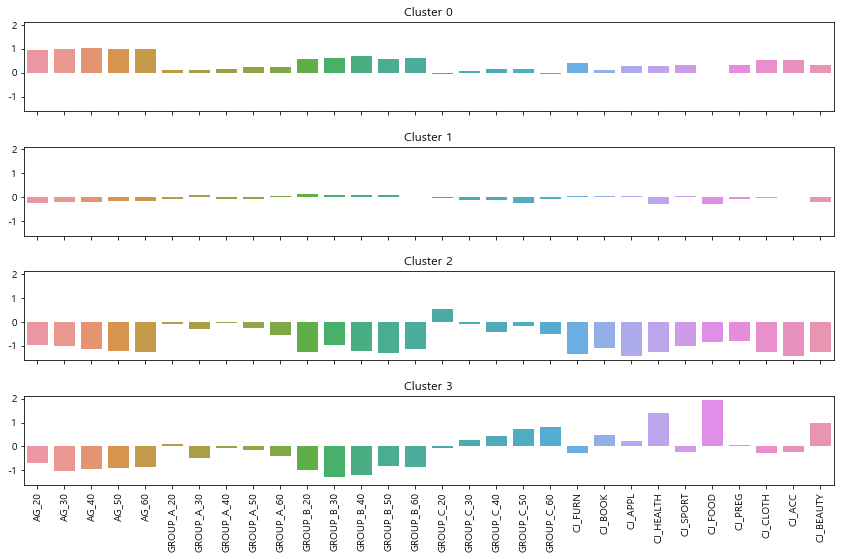

In [59]:
fig, ax = plt.subplots(4, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

for i in range(kmeans.n_clusters):
    ax[i].set_title(f'Cluster {i}')
    sns.barplot(np.arange(test.columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(test.columns.size))
    ax[i].set_xticklabels(test.columns, rotation=90)

In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [61]:
scaler = StandardScaler()
scaled_1 = scaler.fit_transform(features_1)
scaled_2 = scaler.fit_transform(features_2)
scaled_3 = scaler.fit_transform(features_3)
scaled_4 = scaler.fit_transform(features_4)

In [62]:
features_1_scaled = pd.DataFrame(data=scaled_1, index=features_1.index, columns=features_1.columns)
kmeans_1 = KMeans(n_clusters=3, random_state=10)
kmeans_1.fit(features_1_scaled)
features_1_scaled['cluster'] = kmeans_1.labels_
features_1_scaled['cluster'].value_counts()

1    37
2    17
0    15
Name: cluster, dtype: int64

In [63]:
features_2_scaled = pd.DataFrame(data=scaled_2, index=features_2.index, columns=features_2.columns)
kmeans_2 = KMeans(n_clusters=3, random_state=32)
kmeans_2.fit(features_2_scaled)
features_2_scaled['cluster'] = kmeans_2.labels_
features_2_scaled['cluster'].value_counts()

0    34
1    22
2    13
Name: cluster, dtype: int64

In [64]:
features_3_scaled = pd.DataFrame(data=scaled_3, index=features_3.index, columns=features_3.columns)
kmeans_3 = KMeans(n_clusters=3, random_state=32)
kmeans_3.fit(features_3_scaled)
features_3_scaled['cluster'] = kmeans_3.labels_
features_3_scaled['cluster'].value_counts()

1    35
2    23
0    11
Name: cluster, dtype: int64

In [65]:
features_4_scaled = pd.DataFrame(data=scaled_4, index=features_4.index, columns=features_4.columns)
kmeans_4 = KMeans(n_clusters=3, random_state=25)
kmeans_4.fit(features_4_scaled)
features_4_scaled['cluster'] = kmeans_4.labels_
features_4_scaled['cluster'].value_counts()

0    42
1    14
2    13
Name: cluster, dtype: int64

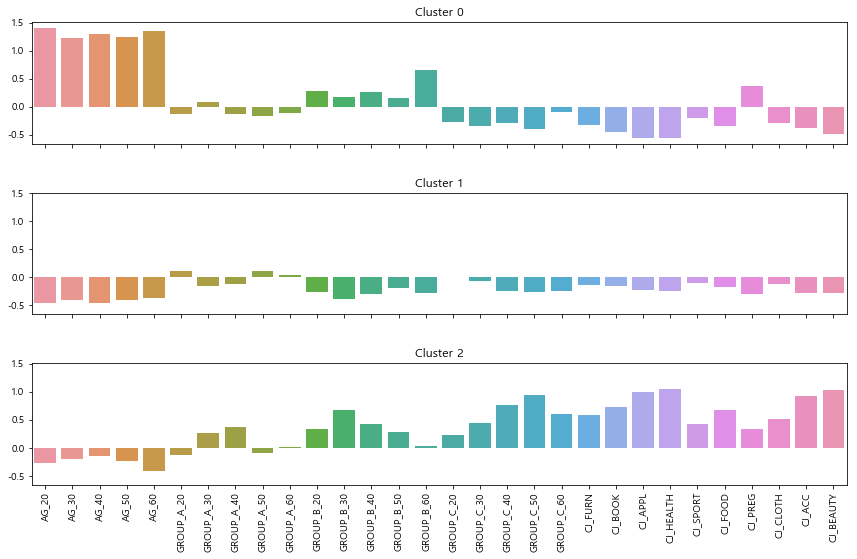

In [66]:
fig, ax = plt.subplots(3, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

for i in range(kmeans_1.n_clusters):
    ax[i].set_title(f'Cluster {i}')
    sns.barplot(np.arange(features_1.columns.size), kmeans_1.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(features_1.columns.size))
    ax[i].set_xticklabels(features_1.columns, rotation=90)

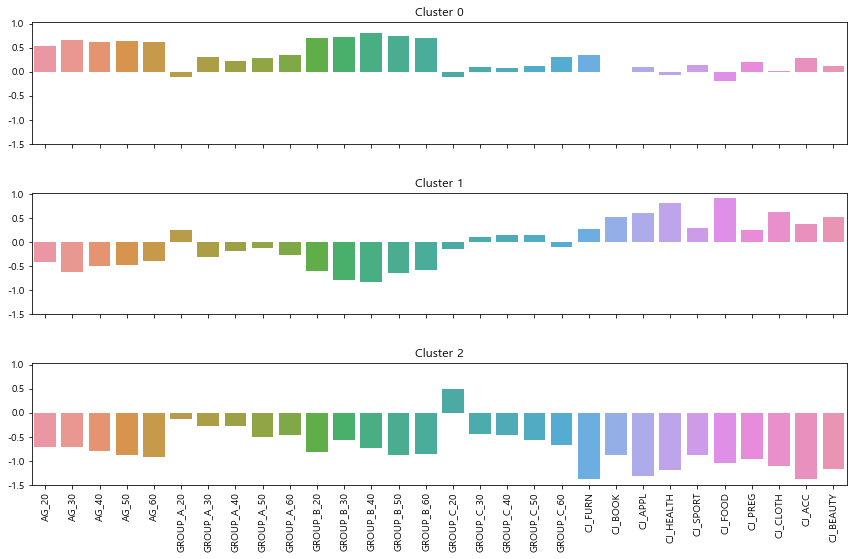

In [67]:
fig, ax = plt.subplots(3, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

for i in range(kmeans_2.n_clusters):
    ax[i].set_title(f'Cluster {i}')
    sns.barplot(np.arange(features_2.columns.size), kmeans_2.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(features_2.columns.size))
    ax[i].set_xticklabels(features_2.columns, rotation=90)

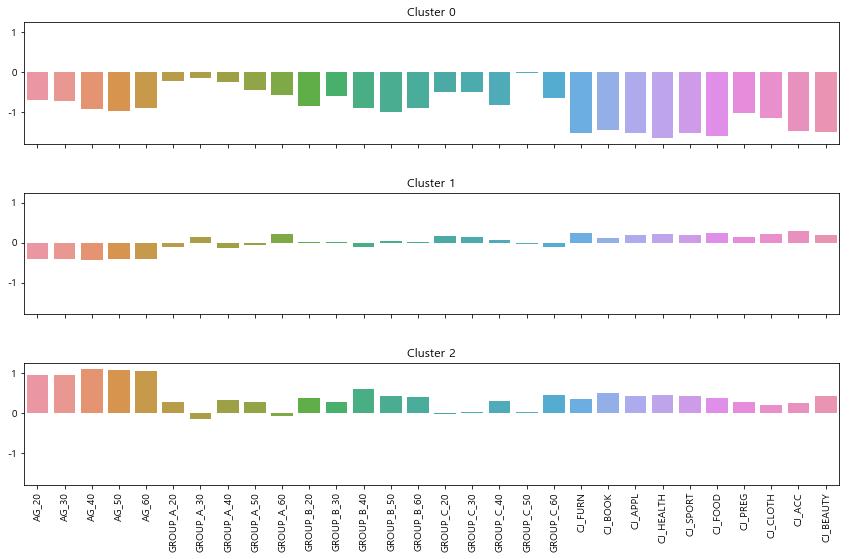

In [68]:
fig, ax = plt.subplots(3, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

for i in range(kmeans_3.n_clusters):
    ax[i].set_title(f'Cluster {i}')
    sns.barplot(np.arange(features_3.columns.size), kmeans_3.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(features_3.columns.size))
    ax[i].set_xticklabels(features_3.columns, rotation=90)

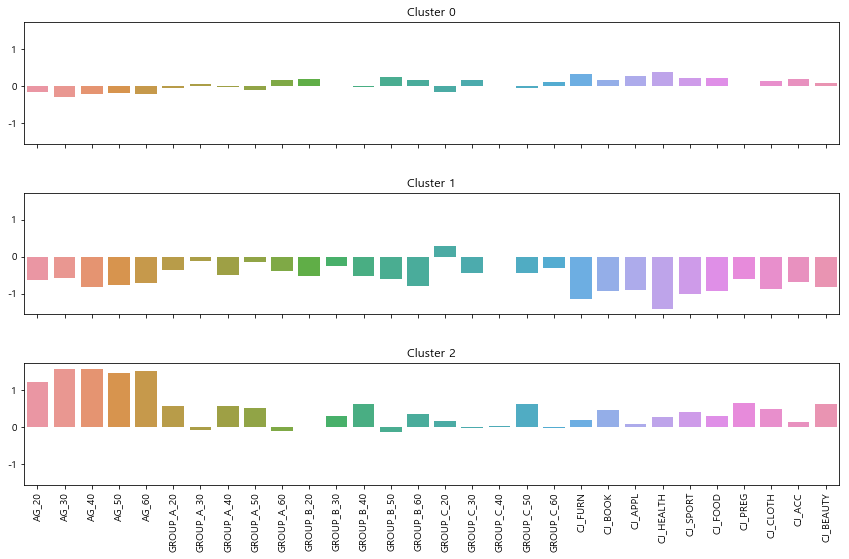

In [69]:
fig, ax = plt.subplots(3, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

for i in range(kmeans_4.n_clusters):
    ax[i].set_title(f'Cluster {i}')
    sns.barplot(np.arange(features_4.columns.size), kmeans_4.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(features_4.columns.size))
    ax[i].set_xticklabels(features_4.columns, rotation=90)

In [60]:
features_1_scaled.groupby('cluster')[features_1_scaled.columns[:-1]].mean()

,AG_20,AG_30,AG_40,AG_50,AG_60,GROUP_A_20,GROUP_A_30,GROUP_A_40,GROUP_A_50,GROUP_A_60,...,CJ_FURN,CJ_BOOK,CJ_APPL,CJ_HEALTH,CJ_SPORT,CJ_FOOD,CJ_PREG,CJ_CLOTH,CJ_ACC,CJ_BEAUTY
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.411189,1.233256,1.294345,1.251667,1.353612,-0.121268,0.083039,-0.121268,-0.168653,-0.118509,...,-0.322252,-0.451734,-0.558526,-0.562288,-0.200525,-0.342563,0.370382,-0.293192,-0.374395,-0.491936
1,-0.451498,-0.412485,-0.453915,-0.402098,-0.361414,0.104880,-0.157817,-0.121268,0.109379,0.043556,...,-0.137763,-0.155223,-0.234241,-0.251524,-0.110284,-0.166939,-0.306092,-0.120991,-0.275044,-0.271493
2,-0.262495,-0.190407,-0.154136,-0.229256,-0.407757,-0.121268,0.270214,0.370937,-0.089250,0.009768,...,0.584177,0.736428,1.002635,1.043571,0.416964,0.665599,0.339392,0.522031,0.928973,1.024958


In [68]:
from yellowbrick.cluster import silhouette_visualizer

ModuleNotFoundError: No module named 'yellowbrick'

In [ ]:
silhouette_visualizer(KMeans(3, random_state=106), features_1_scaled.iloc[:, :-1], colors='yellowbrick')
plt.show()

In [338]:
from som import Som
from pylab import plot, axis, show, pcolor, colorbar, bone

In [339]:
features_scaled = pd.DataFrame(data=scaled_1, index=features_1.index, columns=features_1.columns)
kmeans = KMeans(n_clusters=3, random_state=15)
kmeans.fit(features_1_scaled)
labels = kmeans.labels_

In [340]:
som = Som(8, 8, 50, sigma=1.0, learning_rate=0.7)

som.random_weights_init(scaled_1)

ValueError: could not broadcast input array from shape (30) into shape (50)

In [75]:
print('Initiating SOM')

som.train_random(scaled_1, 20000)
print('\nSOM Processing Complete')

Initiating SOM

SOM Processing Complete


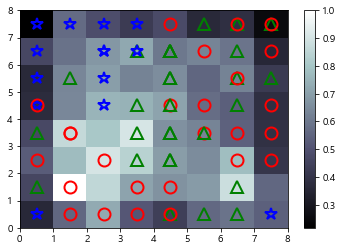

In [77]:
bone()
pcolor(som.distance_map().T)
colorbar()
marker = ['o', '^', '*']
colors = ['r', 'g', 'b']
for cnt, xx in enumerate(scaled_1):
    w = som.winner(xx)
    plot(w[0] + 0.5, w[1] + 0.5, marker[labels[cnt]], mfc='None', mec=colors[labels[cnt]],
         markersize=12, markeredgewidth=2)
    axis([0, som.weights.shape[0], 0, som.weights.shape[1]])

In [295]:
#table.to_csv('../Data/table.csv', index=False)

In [79]:
features_1_scaled

,AG_20_F,AG_30_F,AG_40_F,AG_50_F,AG_60_F,AG_20_M,AG_30_M,AG_40_M,AG_50_M,AG_60_M,...,CJ_BOOK,CJ_APPL,CJ_HEALTH,CJ_SPORT,CJ_FOOD,CJ_PREG,CJ_CLOTH,CJ_ACC,CJ_BEAUTY,cluster
HDONG_NM,,,,,,,,,,,,,,,,,,,,,
고산1동,0.394609,0.358297,0.547091,0.391218,0.322053,0.363285,0.322156,0.442130,0.417890,0.448447,...,0.363419,0.479005,0.299091,0.080384,0.549776,0.442833,0.157504,0.334076,0.422536,1
고산2동,0.180296,0.242053,0.316213,0.302567,0.294049,0.210710,0.273980,0.307221,0.332453,0.392915,...,0.790311,0.679284,0.430437,0.756051,0.823094,0.592737,0.287482,0.564829,0.592602,2
고산3동,0.314270,0.288783,0.473275,0.381953,0.336954,0.327799,0.256633,0.307498,0.318980,0.374160,...,0.508454,0.511678,0.179329,0.272359,0.536397,0.503222,0.181487,0.255795,0.310325,2
공릉1동,0.094601,0.222610,0.240181,0.227182,0.263457,0.159007,0.286529,0.325764,0.247881,0.249407,...,0.514215,0.496855,0.187090,0.253148,0.172248,0.488035,0.204973,0.354491,0.327576,0
공릉2동,0.063886,0.200703,0.193327,0.195554,0.190784,0.160628,0.269575,0.266269,0.225047,0.180815,...,0.555617,0.462238,0.233085,0.269702,0.267377,0.419254,0.168634,0.403154,0.333157,2
광희동,0.089633,0.279196,0.256367,0.226955,0.136459,0.124806,0.343744,0.357141,0.312707,0.161031,...,0.773345,0.568260,0.375112,0.496244,0.185043,0.284735,0.179774,0.563556,0.563019,0
남산1동,0.147159,0.311447,0.343306,0.216970,0.203375,0.134228,0.232396,0.237691,0.164818,0.192782,...,0.795418,0.690868,0.364165,0.616071,0.561679,0.119378,0.261440,0.837865,0.711339,2
남산2동,0.130986,0.275717,0.266956,0.234948,0.213790,0.100677,0.158833,0.151250,0.160881,0.219869,...,0.677674,0.656902,0.357893,0.278172,0.325300,0.293411,0.125272,0.080197,0.688664,2
남산3동,0.128397,0.173641,0.163697,0.124607,0.168492,0.083875,0.137323,0.168235,0.110934,0.217953,...,0.710391,0.511522,0.366951,0.504327,0.588052,0.503331,0.135201,0.493651,0.297181,2
